In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from functools import reduce
import scipy.stats as stat
import scipy.cluster.hierarchy as hierarchy
from sklearn.decomposition import PCA 

In [2]:
fontsize = 16
lw = 2
size = 30
props = dict(boxstyle='round, pad=0.5', facecolor='white', edgecolor='black', 
             linewidth=2, mutation_aspect=0.8, pad=0.3)

blues = sns.color_palette('Blues', 20)
greens = sns.color_palette('Greens', 5)
palette = [greens[1], blues[7], blues[13], blues[19]]

cmap = 'viridis_r'
gamma = '\u03B3'
interferon = 'IFN-' + gamma

In [3]:
path = '01_Data/01_Raw_Protein_Quan/'

raw = pd.read_csv(path + 'IFN_proteinGroups_Azmal_copy.txt', sep='\t')
raw = raw[raw['Blanks'] > 6]  # removing empty rows

filter_cols = ['Only identified by site', 'Reverse', 'Potential contaminant']

for col in filter_cols:
    raw = raw[raw[col] != '+']
    
raw = raw[~raw['Protein IDs'].str.contains('REV')]
raw = raw[raw['Peptides'] > 0].set_index(['Majority protein IDs', 'Gene names'])

quan_cols = [c for c in raw if 'LFQ intensity' in c and 'Rep' in c]
raw = raw[quan_cols].replace(0, np.nan).dropna(how='all')
raw.columns = [c.split(' ')[2].split('_')[0] for c in quan_cols]

C:\Users\k689l\AppData\Local\Temp\ipykernel_18940\4040565635.py:3: DtypeWarning: Columns (131) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(path + 'IFN_proteinGroups_Azmal_copy.txt', sep='\t')


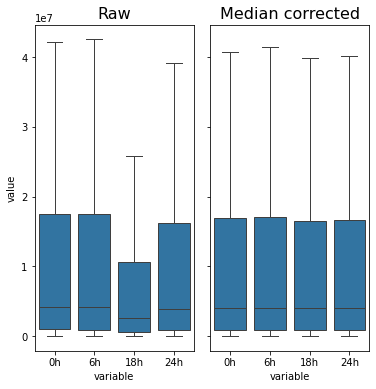

In [4]:
timepoints = ['0h', '6h', '18h', '24h']
tp_labels = [tp.replace('h', ' h') for tp in timepoints]

corr_factors = raw.median().median() / raw.median()
quan = raw.multiply(corr_factors)

fig, ax = plt.subplots(1,2, figsize=(6,6), sharey=True)
plt.subplots_adjust(wspace=0.1)
titles = ['Raw', 'Median corrected']

for i, frame in enumerate([raw, quan]):
    sns.boxplot(data=frame.melt().dropna(), x='variable', y='value', order=timepoints, ax=ax[i], showfliers=False)
    ax[i].set_title(titles[i], fontsize=fontsize)

In [5]:
path2 = '01_Data/02_Annotation_DB/'
ifn_anno = pd.read_csv(path2 + 'comprehensive_IFNy_interactome.tsv', sep='\t')
anno_set = set(ifn_anno['Entry'])
dictionary = dict(zip(ifn_anno['Entry'], ifn_anno['IFN_Database']))

ifn_proteins = []
for row in quan.index.get_level_values(0).astype(str):
    ifn = [prot for prot in row.split(';') if prot in anno_set]
    ifn = [dictionary.get(item, item) for item in ifn]  
    ifn_proteins.append(';'.join(ifn))
quan.loc[:,('IFN_Database')] = ifn_proteins

C:\Users\k689l\AppData\Local\Temp\ipykernel_18940\1899389756.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=count, x=count.index, y=0, capsize=0.12, palette=palette,
C:\Users\k689l\AppData\Local\Temp\ipykernel_18940\1899389756.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tp_labels, fontweight='bold')


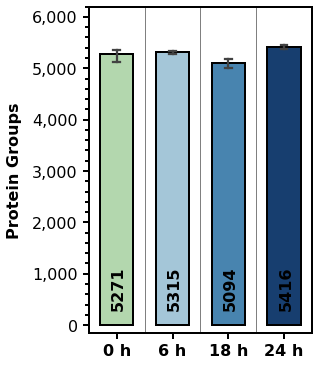

In [6]:
count = pd.DataFrame(quan[timepoints].count())

fig, ax = plt.subplots(1,1, figsize=(4,6))

sns.barplot(data=count, x=count.index, y=0, capsize=0.12, palette=palette, 
            width=0.6, edgecolor='black', linewidth=lw, ax=ax)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.set_xlabel('')
ax.set_ylabel('Protein Groups', fontsize=fontsize, fontweight='bold', labelpad=10)

ax.set_ylim([-150, 6200])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax.minorticks_on()
ax.tick_params(axis='both', which='major', length=lw*3, width=lw, pad=5, labelsize=fontsize)
ax.tick_params(axis='y', which='minor', length=lw*2, width=lw, pad=5)
ax.tick_params(axis='x', which='minor', length=0)
ax.set_xticklabels(tp_labels, fontweight='bold')

for i in range(3):
    ax.axvline(x=(0.5+i), color='grey', linewidth=lw/2)

for i, tp in enumerate(timepoints):
    count_mean = count.loc[tp].mean(axis=0)
    ax.text(x=(i-0.1), y=350, s=round(count_mean[0]), rotation=90, fontweight='bold', fontsize=fontsize)

# plt.savefig('02_Figures/FS_Bulk_ProteinGroups_Barplot.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/FS_Bulk_ProteinGroups_Barplot.pdf', dpi=400, bbox_inches='tight')

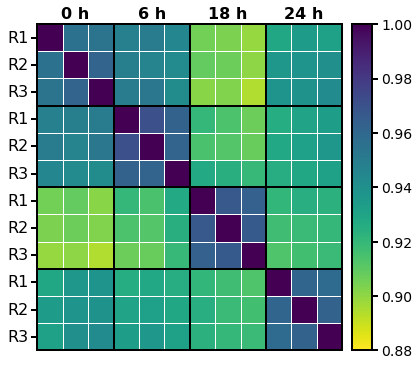

In [7]:
pearson = np.log2(quan[timepoints]).corr(method='pearson')

labels = ['R1', 'R2', 'R3',
          'R1', 'R2', 'R3',
          'R1', 'R2', 'R3',
          'R1', 'R2', 'R3']

fig, ax = plt.subplots(1,2, figsize=(6,6), gridspec_kw={'width_ratios': [15,1]})
plt.subplots_adjust(wspace=0.06)
axs = fig.axes

sns.heatmap(data=pearson, xticklabels=False, yticklabels=labels, vmin=0.88, vmax=1, cmap=cmap,
            linewidth=lw/2, ax=axs[0], cbar_ax=axs[1])

for ax in axs:
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_visible(True)
        ax.spines[axis].set_linewidth(2)
    
axs[0].tick_params(axis='y', which='major', labelsize=fontsize, pad=3, length=lw*3, width=lw, rotation=0)
axs[1].tick_params(axis='y', which='major', labelsize=fontsize-2, pad=3, length=lw*3, width=lw)

for i, tp in enumerate(tp_labels):
    axs[0].text(x=(1.5+3*i), y=-0.2, s=tp, fontsize=fontsize, fontweight='bold', ha='center')

for i in range(3):
    axs[0].axvline(x=(3+3*i), color='k', linewidth=lw)
    axs[0].axhline(y=(3+3*i), color='k', linewidth=lw)
        
# plt.savefig('02_Figures/FS_Bulk_Pearson_Heatmap.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/FS_Bulk_Pearson_Heatmap.pdf', dpi=400, bbox_inches='tight')

E:\KK\03_Programs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
E:\KK\03_Programs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


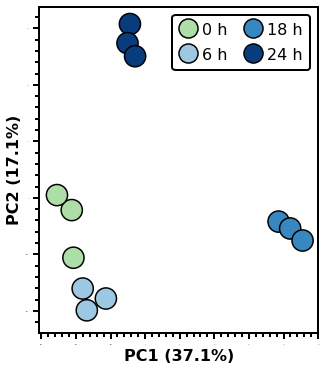

In [8]:
pca_frame = np.log2(quan[timepoints]).dropna().T

pca = PCA(n_components=2).fit_transform(pca_frame)
pca = pd.DataFrame(pca, columns=['x','y'])
pca['Experiment'] = quan[timepoints].columns

fig, ax = plt.subplots(1,1, figsize=(5, 6))

sns.scatterplot(data=pca, x='x', y='y', hue='Experiment', s=size*15, palette=palette, edgecolor='k', linewidth=1.5)

for axis in ['top', 'bottom', 'right', 'left']:
    ax.spines[axis].set_linewidth(2)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=0, length=lw*3, width=lw, pad=5)
ax.tick_params(axis='both', which='minor', length=lw*2, width=lw)

ax.set_xlim([pca['x'].min()*1.2, pca['x'].max()*1.1])
ax.set_ylim([pca['y'].min()*1.2, pca['y'].max()*1.1])

xvar, yvar = PCA(n_components=2).fit(pca_frame).explained_variance_ratio_
ax.set_xlabel('PC1 (' + str(round(xvar * 100, 1)) + '%)', weight='bold', fontsize=fontsize)
ax.set_ylabel('PC2 (' + str(round(yvar * 100, 1)) + '%)', weight='bold', fontsize=fontsize)

handles, lables = ax.get_legend_handles_labels()
legend = plt.legend(handles=handles[0:4], labels=tp_labels, markerscale=0.9, fontsize=fontsize, ncol=2, columnspacing=1.1,
                    handlelength=1, handleheight=1, handletextpad=0.4, edgecolor='k', framealpha=1,
                    labelspacing=0.6, borderpad=0.45, loc=0)
legend.get_frame().set_linewidth(lw)

# plt.savefig('02_Figures/FS_Bulk_PCA.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/FS_Bulk_PCA.pdf', dpi=400, bbox_inches='tight')

In [9]:
medians = pd.DataFrame()
quan_vals = []

for tp in timepoints:
    medians[tp] = np.log2(quan[tp]).median(axis=1)
    quan_vals.append(quan[tp].to_numpy(dtype=float))
      

vdata = pd.DataFrame()
vdata['log fold 6h - 0h'] = medians['6h'].sub(medians['0h'])
vdata['log fold 18h - 0h'] = medians['18h'].sub(medians['0h'])
vdata['log fold 24h - 0h'] = medians['24h'].sub(medians['0h'])

pvals6h = []
pvals18h = []
pvals24h = []

for row in range(medians.shape[0]):
    ttest_result = stat.ttest_ind(quan_vals[1][row, :], quan_vals[0][row, :], nan_policy='omit')
    pvals6h.append(ttest_result[1])
for row in range(medians.shape[0]):
    ttest_result = stat.ttest_ind(quan_vals[2][row, :], quan_vals[0][row, :], nan_policy='omit')
    pvals18h.append(ttest_result[1])
for row in range(medians.shape[0]):
    ttest_result = stat.ttest_ind(quan_vals[3][row, :], quan_vals[0][row, :], nan_policy='omit')
    pvals24h.append(ttest_result[1])

vdata['p-val 6h - 0h'] = list(np.array(pvals6h))
vdata['p-val 18h - 0h'] = list(np.array(pvals18h))
vdata['p-val 24h - 0h'] = list(np.array(pvals24h))

for tp in timepoints[1:4]:
    vdata['log p-val ' + tp + ' - 0h'] = -1*np.log10(vdata['p-val ' + tp + ' - 0h'])
    
    rank = vdata['p-val ' + tp + ' - 0h'].rank()
    padj = vdata['p-val ' + tp + ' - 0h'] * rank.max() / rank
    vdata['log padj ' + tp + ' - 0h'] = -1*np.log10(padj)
        
vdata['IFN_Database'] = quan['IFN_Database']
p_cols = [c for c in vdata if 'p-val' in c]
vdata = vdata.dropna(how='all', subset=p_cols)

path3 = '01_Data/04_Exports/'
# vdata.to_csv(path3 + 'vdata.tsv', sep='\t')

E:\KK\03_Programs\Anaconda3\lib\site-packages\scipy\stats\mstats_basic.py:1077: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
C:\Users\k689l\AppData\Local\Temp\ipykernel_18940\618133189.py:28: UserWarning: Warning: converting a masked element to nan.
  vdata['p-val 6h - 0h'] = list(np.array(pvals6h))
C:\Users\k689l\AppData\Local\Temp\ipykernel_18940\618133189.py:29: UserWarning: Warning: converting a masked element to nan.
  vdata['p-val 18h - 0h'] = list(np.array(pvals18h))
C:\Users\k689l\AppData\Local\Temp\ipykernel_18940\618133189.py:30: UserWarning: Warning: converting a masked element to nan.
  vdata['p-val 24h - 0h'] = list(np.array(pvals24h))


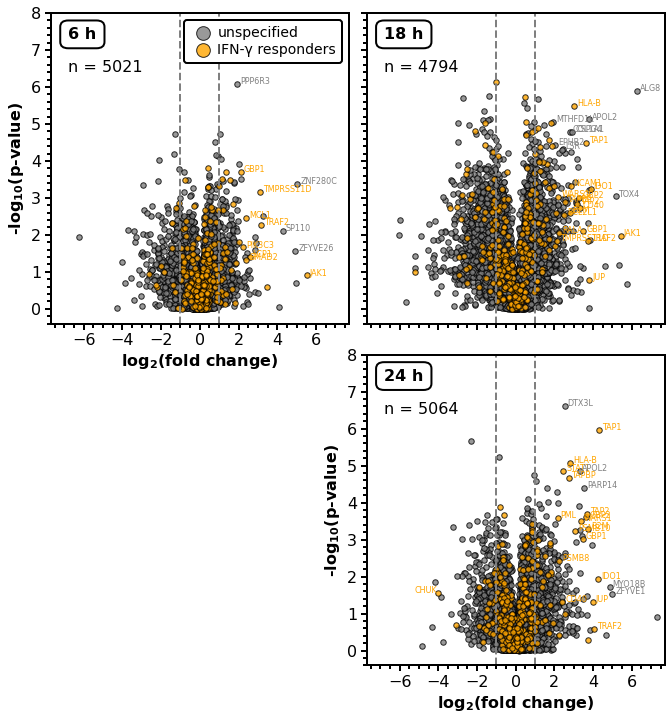

In [10]:
vdata1 = vdata[vdata['IFN_Database'] == '']
vdata2 = vdata[vdata['IFN_Database'] != '']

fig, ax = plt.subplots(2,2, figsize=(11,12))
plt.subplots_adjust(wspace=0.06, hspace=0.1)
fig.delaxes(ax[1,0])
axs = fig.axes

xticks = [-6, -4, -2, 0, 2, 4, 6]

for i, tp in enumerate(timepoints[1:4]):
    
    fc = 'log fold ' + tp + ' - 0h'
    pv = 'log p-val ' + tp + ' - 0h'
    
    sns.scatterplot(data=vdata1, x=fc, y=pv, s=size, c='grey', alpha=0.8, edgecolor='black', linewidth=lw/2, ax=axs[i])
    sns.scatterplot(data=vdata2, x=fc, y=pv, s=size, c='orange', alpha=0.8, edgecolor='black', linewidth=lw/2, ax=axs[i])
    
    for axis in ['top', 'bottom', 'left', 'right']:
        axs[i].spines[axis].set_linewidth(2)

    axs[i].set_xlim([-7.7, 7.7])
    axs[i].set_ylim([-0.4, 8])
    
    axs[i].minorticks_on()
    axs[i].tick_params(axis='both', which='major', labelsize=fontsize, length=lw*3, width=lw)
    axs[i].tick_params(axis='both', which='minor', length=lw*2, width=lw)
    axs[i].set_xticks(xticks)
    
    axs[i].axvline(x=1, linestyle='dashed', color='grey', linewidth=lw)
    axs[i].axvline(x=-1, linestyle='dashed', color='grey', linewidth=lw)
    
    axs[i].set_ylabel(ylabel='-log'+r'$\bf{_{10}}$'+'(p-value)', fontsize=fontsize, weight='bold', labelpad=5)  
    
    axs[i].text(-6.8, 7.3, s=tp_labels[i+1], fontsize=fontsize, weight='bold', bbox=props)
    axs[i].text(-6.8, 6.4, 'n = ' + str(len(vdata.dropna(subset=pv))), fontsize=fontsize)  
    
    for j in range(vdata2.shape[0]):
        if vdata2[fc][j] > 2.1 and vdata2[pv][j] > 1:
            axs[i].text(vdata2[fc][j]+0.15, vdata2[pv][j], s=vdata2['IFN_Database'][j], fontsize=fontsize/2, c='orange')
        elif vdata2[fc][j] > 3.5 and vdata2[pv][j] > 0.5:
            axs[i].text(vdata2[fc][j]+0.15, vdata2[pv][j], s=vdata2['IFN_Database'][j], fontsize=fontsize/2, c='orange')
        elif vdata2[fc][j] < -4 and vdata2[pv][j] > 1:
            axs[i].text(vdata2[fc][j]-1.2, vdata2[pv][j], s=vdata2['IFN_Database'][j], fontsize=fontsize/2, c='orange')
    for j in range(vdata1.shape[0]):
        if vdata1[fc][j] > 4 and vdata1[pv][j] > 1.5:
            axs[i].text(vdata1[fc][j]+0.15, vdata1[pv][j], s=vdata1.index.get_level_values(1)[j], fontsize=fontsize/2, c='grey')
        elif vdata1[fc][j] > 1.9 and vdata1[pv][j] > 4.3:
            axs[i].text(vdata1[fc][j]+0.15, vdata1[pv][j], s=vdata1.index.get_level_values(1)[j], fontsize=fontsize/2, c='grey')
                
#     line_y = vdata[vdata['log padj ' + tp + ' - 0h'] > 1.3][pv].min()
#     axs[i].axhline(y=line_y, linestyle='dashed', color='grey', linewidth=lw)
    
# axs[0].text(x=-7.2, y=4, s='adj. p ' + '= 0.05', fontsize=fontsize-4, color='grey')

axs[0].set_xlabel('log'+r'$\bf{_{2}}$'+'(fold change)', fontsize=fontsize, weight='bold')
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[2].set_xlabel('log'+r'$\bf{_{2}}$'+'(fold change)', fontsize=fontsize, weight='bold')

axs[1].set_xticklabels([])
axs[1].set_yticklabels([])

legend = axs[0].legend(labels=['unspecified', interferon + ' responders'], markerscale=2.5, ncol=1, fontsize=fontsize-2,
                       columnspacing=1.1, handletextpad=0, edgecolor='k', framealpha=1, labelspacing=0.25, loc=1)
legend.get_frame().set_linewidth(lw)

# plt.savefig('02_Figures/FS_Bulk_Volcanos.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/FS_Bulk_Volcanos.pdf', dpi=400, bbox_inches='tight')

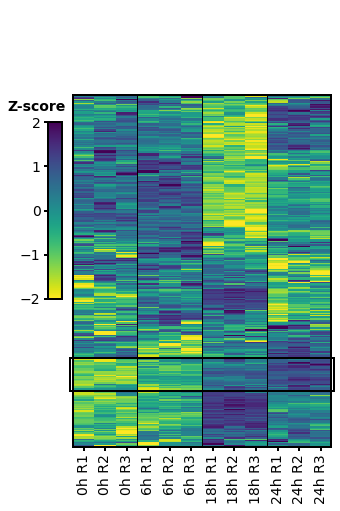

In [11]:
ifn_data = quan[quan['IFN_Database'] != '']
ifn_data = np.log2(ifn_data.reset_index().set_index('IFN_Database')[timepoints].dropna())

rep_labels = ['0h R1', '0h R2', '0h R3', '6h R1', '6h R2', '6h R3', 
              '18h R1', '18h R2', '18h R3', '24h R1', '24h R2', '24h R3']
ifn_data.columns = rep_labels

vmin = -2
vmax = 2
cbar_pos=(0.14,0.4,0.04,0.35)

clustermap = sns.clustermap(ifn_data, metric='euclidean', z_score=0, figsize=(5,7), col_cluster=False,
                            cmap=cmap, cbar_pos=cbar_pos, vmin=vmin, vmax=vmax, yticklabels=False)
clustermap.ax_row_dendrogram.set_visible(False)

heatmap = clustermap.ax_heatmap
cbar = clustermap.cax

heatmap.tick_params(axis='x', which='major', pad=3, length=lw*2, width=lw, labelsize=fontsize-2)
heatmap.tick_params(axis='y', length=0)
heatmap.set_ylabel('')

for axis in ['top', 'bottom', 'left', 'right']:
    heatmap.spines[axis].set_visible(True)
    heatmap.spines[axis].set_linewidth(lw)
    
    cbar.spines[axis].set_visible(True)
    cbar.spines[axis].set_linewidth(lw)

cbar.yaxis.tick_left()
cbar.yaxis.set_label_position('left')
cbar.tick_params(axis='y', which='major', pad=3, length=lw*2, width=lw, labelsize=fontsize-2)
cbar.text(x=-2.8, y=vmax+0.25, s='Z-score', weight='bold', fontsize=fontsize-2)

for x in [3, 6, 9]:
    heatmap.axvline(x=x, linestyle='solid', color='black', linewidth=lw/2)

# cluster in heatmap
width = 12.25
cluster_upper = 215
cluster_lower = 242
  
xy = (-0.15, cluster_upper)    
height = cluster_lower - cluster_upper

rect = mpl.patches.Rectangle(xy, width, height, linewidth=lw, edgecolor='black', facecolor='none', alpha=1, clip_on=False)
heatmap.add_patch(rect)

new_ind = ifn_data.index[clustermap.dendrogram_row.reordered_ind]
clustered = ifn_data.loc[new_ind,:].reset_index()

# plt.savefig('02_Figures/FS_Bulk_Cluster_Heatmap.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/FS_Bulk_Cluster_Heatmap.pdf', dpi=400, bbox_inches='tight')

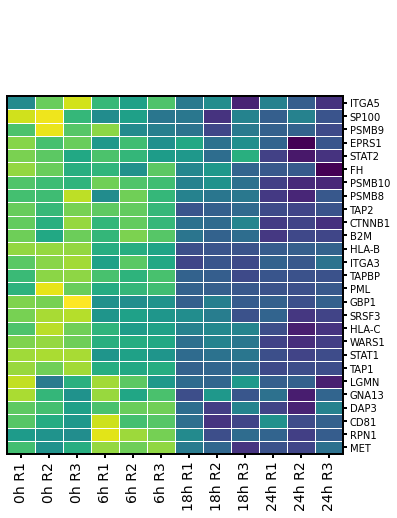

In [12]:
cluster = clustered[cluster_upper:cluster_lower].set_index('IFN_Database')

figsize_y = len(cluster) / 3.8
cbar_pos = (0.85,0.4,0.03,0.35)

clustermap = sns.clustermap(cluster, metric='euclidean', z_score=0, figsize=(7,figsize_y), col_cluster=False, 
                            linewidths=lw/4, cmap=cmap, cbar_pos=cbar_pos, vmin=vmin, vmax=vmax) 
clustermap.cax.remove()
clustermap.ax_row_dendrogram.set_visible(False)

heatmap = clustermap.ax_heatmap

heatmap.set_ylabel('')

heatmap.tick_params(axis='y', which='major', pad=3, length=lw*2, width=lw, labelsize=fontsize-6)
heatmap.tick_params(axis='x', which='major', pad=3, length=lw*2, width=lw, labelsize=fontsize-2)

for axis in ['top', 'bottom', 'left', 'right']:
    heatmap.spines[axis].set_visible(True)
    heatmap.spines[axis].set_linewidth(lw)

# plt.savefig('02_Figures/FS_Bulk_Cluster_Up-regulation.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/FS_Bulk_Cluster_Up-regulation.pdf', dpi=400, bbox_inches='tight')

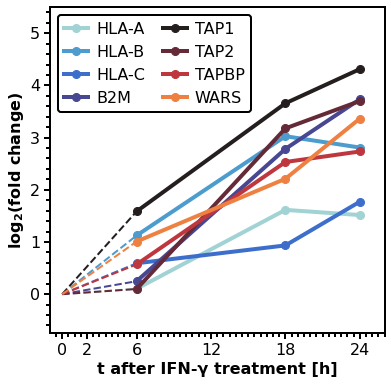

In [13]:
gene_list = ['HLA-A', 'HLA-B', 'HLA-C', 'B2M', 'TAP1', 'TAP2', 'TAPBP', 'WARS']
g_palette = sns.color_palette('icefire', len(gene_list)*3)
colors = [g_palette[0], g_palette[3], g_palette[5], g_palette[7], 
          g_palette[12], g_palette[15], g_palette[18], g_palette[21]]
series = [6, 18, 24]

g_data = vdata[vdata.index.get_level_values(1).isin(gene_list)][[c for c in vdata if 'fold' in c]]
g_data.columns = series
g_data = g_data.droplevel('Majority protein IDs').T

fig, ax = plt.subplots(1,1,figsize=(6,6))

handles = []
for gene, color in zip(gene_list, colors):
    ax.plot(g_data[gene], marker='o', linewidth=lw*2, markersize=8, c=color)
    
    xx = [0, 6]
    yy = [0, g_data[gene].iloc[0]]
    ax.plot(xx, yy, linestyle='dashed', linewidth=lw, markersize=8, c=color)
    
    line = mpl.lines.Line2D([], [], color=color, marker='o', lw=lw*2, markersize=8, label=gene)
    handles.append(line)
    
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(lw)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=fontsize, length=lw*3, width=lw)
ax.tick_params(axis='both', which='minor', labelsize=fontsize, length=lw*2, width=lw)

ax.set_xlabel('t after ' + interferon + ' treatment [h]', fontsize=fontsize, weight='bold')
ax.set_ylabel('log'+r'$\bf{_{2}}$'+'(fold change)', fontsize=fontsize, weight='bold', labelpad=4)

ax.set_xticks([0, 2, 6, 12, 18, 24])
ax.set_ylim([-0.75, 5.5])
ax.set_xlim([-1, 26])

legend = ax.legend(handles=handles, labels=gene_list, fontsize=fontsize, ncol=2, columnspacing=1.1, 
                   handlelength=1.5, handleheight=0.5, handletextpad=0.5, edgecolor='k', framealpha=1)
legend.get_frame().set_linewidth(lw)

# plt.savefig('02_Figures/FS_Bulk_Genes_Lineplot.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/FS_Bulk_Genes_Lineplot.pdf', dpi=400, bbox_inches='tight')

C:\Users\k689l\AppData\Local\Temp\ipykernel_18940\1015709577.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_data['Base'] = g_data[[c for c in g_data if '0h' in c]].mean(axis=1)


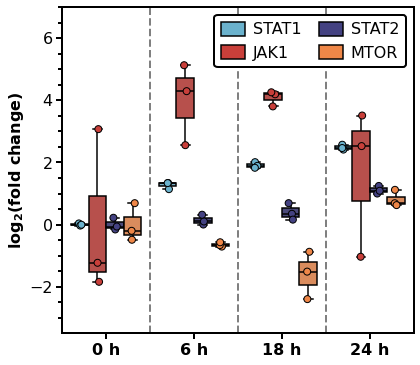

In [14]:
gene_list = ['STAT1', 'JAK1', 'STAT2', 'MTOR']
g_palette = sns.color_palette('icefire', len(gene_list)*2)
colors = [g_palette[0], g_palette[6], g_palette[2], g_palette[7]]

g_data = ifn_data[ifn_data.index.isin(gene_list)]
g_data['Base'] = g_data[[c for c in g_data if '0h' in c]].mean(axis=1)
g_data = g_data.apply(lambda row: row - row.iloc[-1], axis=1)

g_melt = g_data.melt(ignore_index=False)
g_melt = g_melt[g_melt['variable'] != 'Base']
g_melt['variable'] = [row.split(' ')[0].replace('h', ' h') for row in g_melt['variable']] 

fig, ax = plt.subplots(1,1, figsize=(6.3,6))

sns.boxplot(data=g_melt, y='value', x='variable', hue=g_melt.index, linewidth=lw-0.5,
            hue_order=gene_list, ax=ax, palette=colors, linecolor='k')
sns.stripplot(data=g_melt, y='value', x='variable', hue=g_melt.index, dodge=True, linewidth=lw/2, size=7,
            hue_order=gene_list, ax=ax, palette=colors, edgecolor='k')

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(lw)
    
ax.set_ylim([-3.5, 7])
ax.set_ylabel('log'+r'$\bf{_{2}}$'+'(fold change)', fontsize=fontsize, weight='bold', labelpad=3)
ax.set_xlabel('')

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=fontsize, length=lw*3, width=lw)
ax.tick_params(axis='y', which='minor', labelsize=fontsize, length=lw*2, width=lw)
ax.tick_params(axis='x', which='minor', length=0)
plt.setp(ax.get_xticklabels(), fontweight='bold')

for i in range(3):
    ax.axvline(x=(0.5+i), linewidth=lw, color='grey', linestyle='dashed')

handles = []
for color in colors:
    handles.append(mpl.patches.Patch(facecolor=color, edgecolor='black', lw=lw-0.5))

legend = ax.legend(handles=handles, labels=gene_list, fontsize=fontsize, ncol=2, columnspacing=1.1,
                   handlelength=1.5, handleheight=1, handletextpad=0.5, edgecolor='k', framealpha=1)
legend.get_frame().set_linewidth(2)

# plt.savefig('02_Figures/FS_Bulk_Genes_Boxplot.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/FS_Bulk_Genes_Boxplot.pdf', dpi=400, bbox_inches='tight')

C:\Users\k689l\AppData\Local\Temp\ipykernel_18940\2076480830.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hm, x='Fold Enrichment', y='Pathway', palette=colormap(rescale(hm['Enrichment FDR'])),
C:\Users\k689l\AppData\Local\Temp\ipykernel_18940\2076480830.py:15: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=hm, x='Fold Enrichment', y='Pathway', palette=colormap(rescale(hm['Enrichment FDR'])),
C:\Users\k689l\AppData\Local\Temp\ipykernel_18940\2076480830.py:46: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  axs[1].set_yticks([])


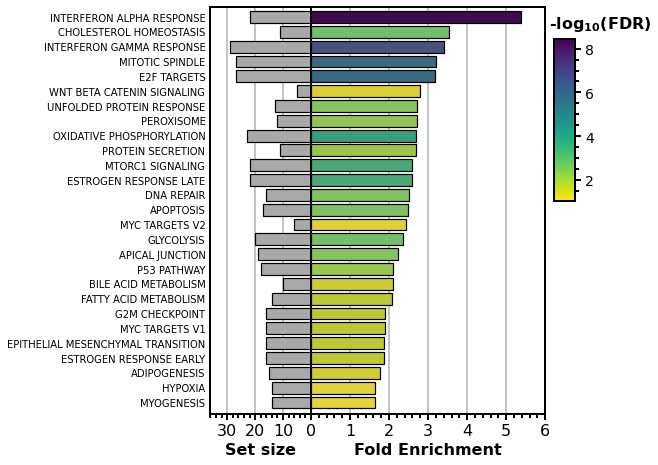

In [15]:
path4 = '01_Data/03_Enrichments/'

hm = pd.read_csv(path4 + 'HallMark_KK27_Bulk_FoldChanges.csv')
hm['Pathway'] = hm['Pathway'].str.slice(9, 50)
hm['Enrichment FDR'] = -1*np.log10(hm['Enrichment FDR'])
hm.sort_values(by='Fold Enrichment', ascending=False, inplace=True)

fig, ax = plt.subplots(1,2, figsize=(6,7.5), gridspec_kw={'width_ratios': [3, 7]})
plt.subplots_adjust(wspace=0)
axs = fig.axes

colormap = plt.get_cmap(cmap)
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

sns.barplot(data=hm, x='Fold Enrichment', y='Pathway', palette=colormap(rescale(hm['Enrichment FDR'])), 
            edgecolor='k', lw=1.2, zorder=2, ax=axs[1])
sns.barplot(data=hm, x='nGenes', y='Pathway', color='darkgrey', edgecolor='k', lw=1.2, zorder=2, ax=axs[0])
    
for ax in axs:
    
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(lw)
    
    ax.grid(axis='x', which='major', linewidth=lw-0.5, zorder=0)
    
    ax.minorticks_on()
    ax.tick_params(axis='x', which='major', length=lw*3, width=lw, labelsize=fontsize)
    ax.tick_params(axis='x', which='minor', length=lw*2, width=lw)
    
    ax.tick_params(axis='y', which='major', length=0, labelsize=fontsize-6, pad=5)
    ax.tick_params(axis='y', which='minor', length=0)

    ax.set_ylabel('')
    ax.set_ylim(len(hm)-0.2, -0.7)
    

axs[0].set_xlabel('Set size', fontsize=fontsize, fontweight='bold')
axs[0].set_xlim(0, 36)
axs[0].set_xticks([10, 20, 30])
axs[0].invert_xaxis()


axs[1].set_xlabel('Fold Enrichment', fontsize=fontsize, fontweight='bold')
axs[1].set_xlim(0, 6)
axs[1].set_xticks(range(7))
axs[1].set_yticks([])

norm = mpl.colors.Normalize(vmin=hm['Enrichment FDR'].min(), vmax=hm['Enrichment FDR'].max())

axs[1].text(x=6.1, y=0.8, s='-log'+r'$\bf{_{10}}$'+'(FDR)', fontsize=fontsize, weight='bold')
cbar_ax = plt.axes([0.92,0.52,0.05,0.3])
cbar = mpl.colorbar.Colorbar(cbar_ax, cmap=cmap, norm=norm, orientation='vertical')
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(lw)
cbar_ax.minorticks_on()
cbar_ax.tick_params(axis='y', which='major', length=lw*3, width=lw, labelsize=fontsize-2)
cbar_ax.tick_params(axis='y', which='minor', length=lw*2, width=lw)

# plt.savefig('02_Figures/FS_Bulk_MSigDB_Enrichment.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/FS_Bulk_MSigDB_Enrichment.pdf', dpi=400, bbox_inches='tight')